In [723]:
# !pip install numpy
# !pip install matplotlib
# !pip install pandas
# !pip install seaborn
# !pip install scikit-learn
# !pip install statsmodels
# !pip install flask
# !pip install requests


In [724]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import statsmodels.api as sm
from sklearn.metrics import (
mean_squared_error as mse,
mean_absolute_error as mae,
mean_absolute_percentage_error as mape
)



In [743]:
# Helper functions
def model_performance(actual, predicted):
    print('MSE:', round(mse(actual, predicted), 3))
    print('MAE:', round(mae(actual, predicted), 3))
    print('RMSE:', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

    return {'MSE': round(mse(actual, predicted), 3),
            'MAE': round(mae(actual, predicted), 3),
            'RMSE': round(mse(actual, predicted)**0.5, 3),
            'MAPE': round(mape(actual, predicted), 3)}

# Exercise 1 Weather Forecast

### Load Data

In [726]:
df_wf = pd.read_csv('spark_renewable_ds_forecast_challenge.csv')
df_wf.head()

,TimeStamp (UTC),WindDirection Avg,WindSpeed Avg,WindSpeed StdDev,T AMB Avg,In AirDensity Avg
0,2021-01-01 06:00:00+00:00,NaN,5.110103,NaN,-0.896897,NaN
1,2021-01-01 07:00:00+00:00,NaN,5.221429,NaN,-0.847589,NaN
2,2021-01-01 08:00:00+00:00,NaN,5.411667,NaN,-1.000000,NaN
3,2021-01-01 09:00:00+00:00,NaN,4.855000,NaN,-1.000000,NaN
4,2021-01-01 10:00:00+00:00,NaN,4.369630,NaN,-0.398102,NaN


## Exploratory Data Analysis

### Checking the data

In [727]:
df_wf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TimeStamp (UTC)    8760 non-null   object 
 1   WindDirection Avg  6568 non-null   float64
 2   WindSpeed Avg      8740 non-null   float64
 3   WindSpeed StdDev   8625 non-null   float64
 4   T AMB Avg          8740 non-null   float64
 5   In AirDensity Avg  8469 non-null   float64
dtypes: float64(5), object(1)
memory usage: 410.8+ KB


**Features**
Data set contains measurements that are averaged over hour. The measurements are taken during the year of 2021 between the months of January to December.

- `TimeStamp (UTC)` - Time stamp (hourly)
- `WindDirection Avg` - Wind Direction measurement
- `WindSpeed Avg` - Wind Speed measurement (Forecast variable)
- `WindSpeed StdDev ` - Std Dev in Wind Speed measurement 
- `T AMB Avg` - Ambient temperature measurement
- `IN AirDensity Avg` - Air density measurement


`WindSpeed StdDev` variable is confusing because Std Dev values are normally associated with measuring device and defined during calibration (but this quantity varying with time). `WindSpeed Avg` is the forecast variable, so it is safe to assume that Std Dev will not be available at forecast time of cannot be used as predictor for the forecast.

The dataset has missing values in all columns except for `TimeStamp (UTC)`. TimeStamp column shall be transformed to datetime for further analysis.

In [728]:
# Converting TimeStamp (UTC) to datetime
df_wf['TimeStamp (UTC)'] = pd.to_datetime(df_wf['TimeStamp (UTC)'])
# Setting TimeStamp (UTC) as index
df_wf.set_index('TimeStamp (UTC)', inplace=True)
# Descriptive stats on dataset
df_wf.describe()

,WindDirection Avg,WindSpeed Avg,WindSpeed StdDev,T AMB Avg,In AirDensity Avg
count,6568.000000,8740.000000,8625.000000,8740.000000,8469.000000
mean,181.787693,7.576278,0.985862,19.905797,1.067147
std,30.272684,3.281039,0.314137,8.424837,0.118506
min,-51.899122,0.372140,0.118535,-15.211083,0.999087
25%,175.994230,5.106686,0.749099,14.670648,1.043655
50%,185.435140,7.210629,0.927381,20.956532,1.060915
75%,193.144781,9.868960,1.166837,25.917942,1.083602
max,401.379430,19.510914,3.098841,39.186423,11.564772


array([<Axes: xlabel='TimeStamp (UTC)'>, <Axes: xlabel='TimeStamp (UTC)'>,
       <Axes: xlabel='TimeStamp (UTC)'>, <Axes: xlabel='TimeStamp (UTC)'>,
       <Axes: xlabel='TimeStamp (UTC)'>], dtype=object)

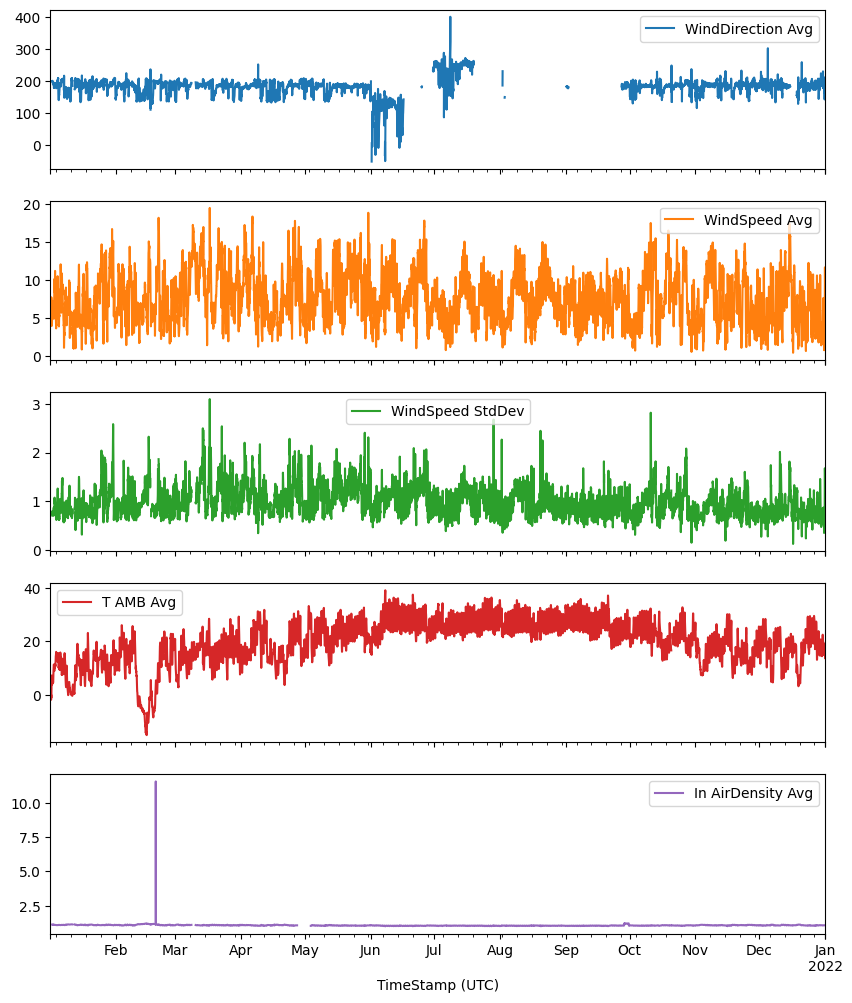

In [729]:
df_wf.plot(subplots=True, figsize=(10, 12))
# days=90
# df_wf.iloc[:days*24,:].plot(subplots=True, figsize=(10, 12))

**Observations**
- **Missing values:** Wind direction is missing most values followed by Air Density.
- **Outliers:** Wind Direction, Ambient temperature columns and Air Density columns contains clear outliers. 



array([[<Axes: title={'center': 'WindDirection Avg'}>,
        <Axes: title={'center': 'WindSpeed Avg'}>],
       [<Axes: title={'center': 'WindSpeed StdDev'}>,
        <Axes: title={'center': 'T AMB Avg'}>],
       [<Axes: title={'center': 'In AirDensity Avg'}>, <Axes: >]],
      dtype=object)

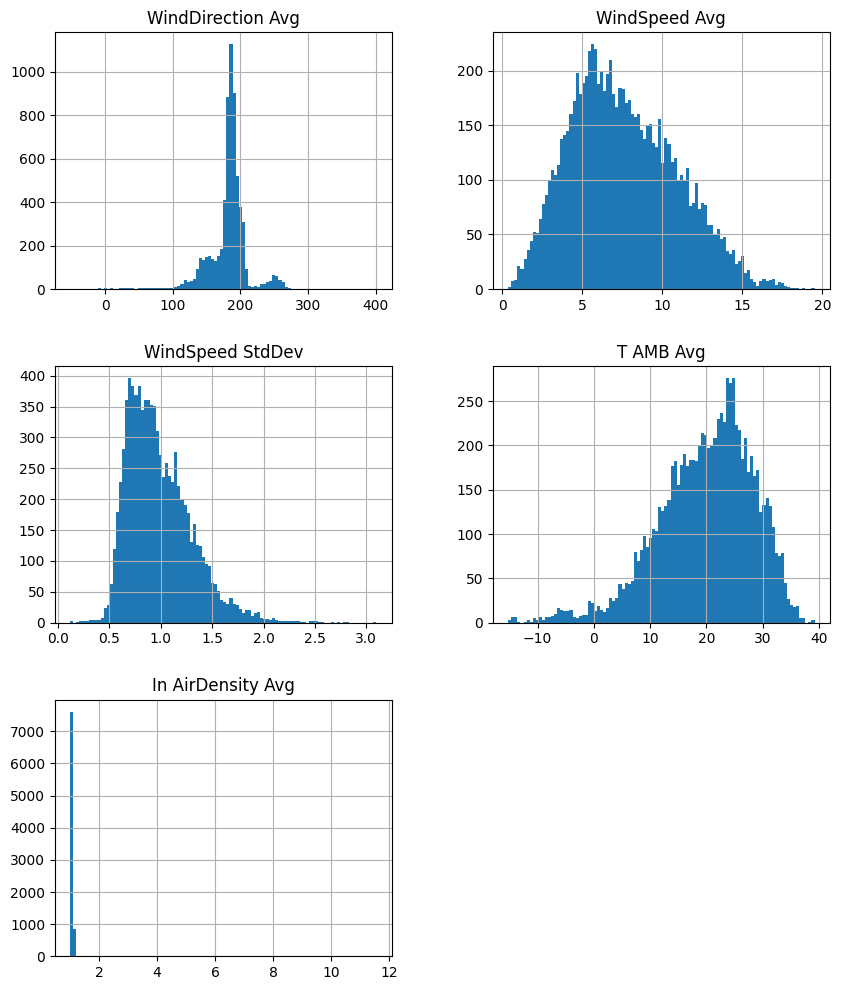

In [730]:
# df_wf(figsize=(10, 12))
# plot histogram of each parameter with kde curve
# df_wf.map(lambda x: np.sqrt(x)).hist(figsize=(10, 12))
df_wf.hist(figsize=(10, 12), bins=100)

## Data Cleaning

### Handling missing values

There are lot of missing values in data. Use linear interpolation method to fill in missing values

<!-- We will use **Centered Moving Average** method to fill in the missing values in data. -->

array([<Axes: xlabel='TimeStamp (UTC)'>, <Axes: xlabel='TimeStamp (UTC)'>,
       <Axes: xlabel='TimeStamp (UTC)'>, <Axes: xlabel='TimeStamp (UTC)'>,
       <Axes: xlabel='TimeStamp (UTC)'>], dtype=object)

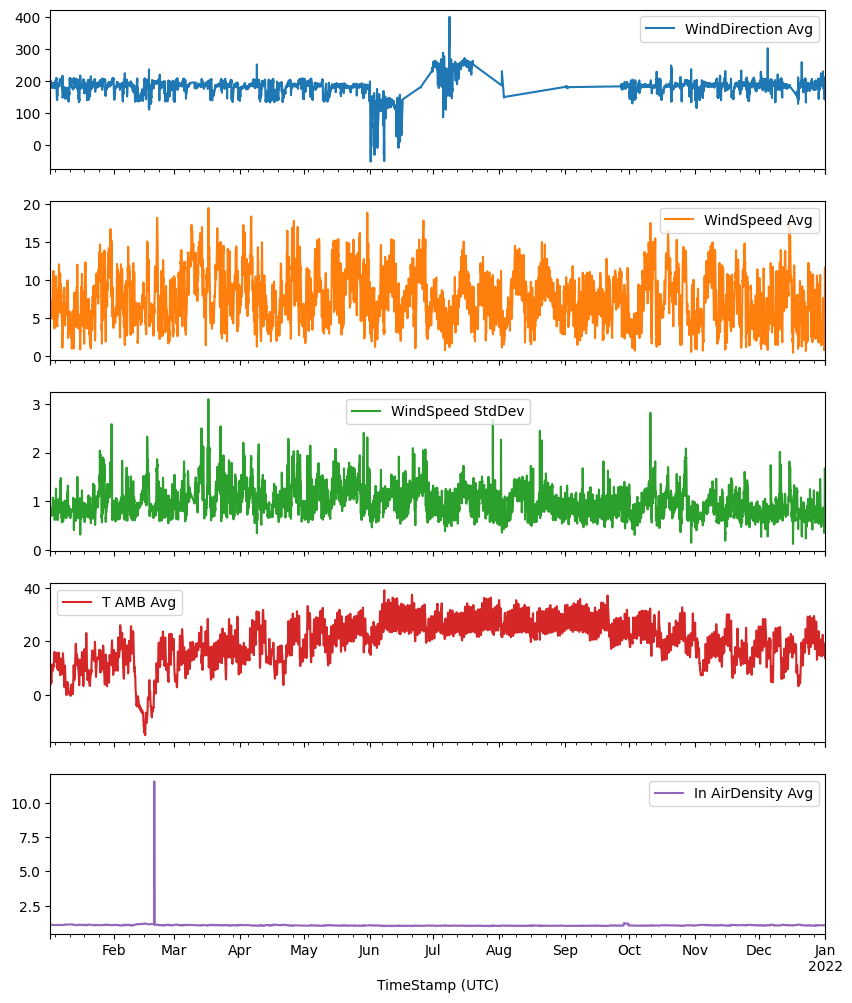

In [731]:
# WindSpeed Avg 
df_clean = df_wf.copy()
df_clean['WindSpeed Avg']=df_clean['WindSpeed Avg'].interpolate(method='linear')
# WindSpeed StdDev
df_clean['WindSpeed StdDev']=df_clean['WindSpeed StdDev'].interpolate(method='linear')
# WindDirection Avg
df_clean['WindDirection Avg']=df_clean['WindDirection Avg'].interpolate(method='linear')#.plot(label='interpolated')
# Temperature Avg
df_clean['T AMB Avg']=df_clean['T AMB Avg'].interpolate(method='linear')
# Air Density Avg
df_clean['In AirDensity Avg']=df_clean['In AirDensity Avg'].interpolate(method='linear')

# Dropping rows with NaN values
df_clean = df_clean.dropna()

df_clean.plot(subplots=True, figsize=(10, 12))
# df_clean.isna().sum()

### Handling outliers

Outliers is unusual data point in the data set which stands out of the data. We will use quantiles to handle the outliers in data.

We choose 98% quantile as upper limit and 2% as lower limit to clip the data of outliers

WindDirection Avg
Min= -51.89912224 Max= 401.3794301 98% 251.22881005255388 2% 117.78457466
WindSpeed Avg
Min= 0.372139804 Max= 19.51091354 98% 14.698864282000004 2% 1.9676620582000002
WindSpeed StdDev
Min= 0.11853506 Max= 3.098840992 98% 1.785460852400001 2% 0.543490588
T AMB Avg
Min= -15.21108292 Max= 39.18642335 98% 33.483925144000004 2% -0.9378562901999994
In AirDensity Avg
Min= 0.999086859 Max= 11.56477199 98% 1.1577409398 2% 1.0179324224


array([<Axes: xlabel='TimeStamp (UTC)'>, <Axes: xlabel='TimeStamp (UTC)'>,
       <Axes: xlabel='TimeStamp (UTC)'>, <Axes: xlabel='TimeStamp (UTC)'>,
       <Axes: xlabel='TimeStamp (UTC)'>], dtype=object)

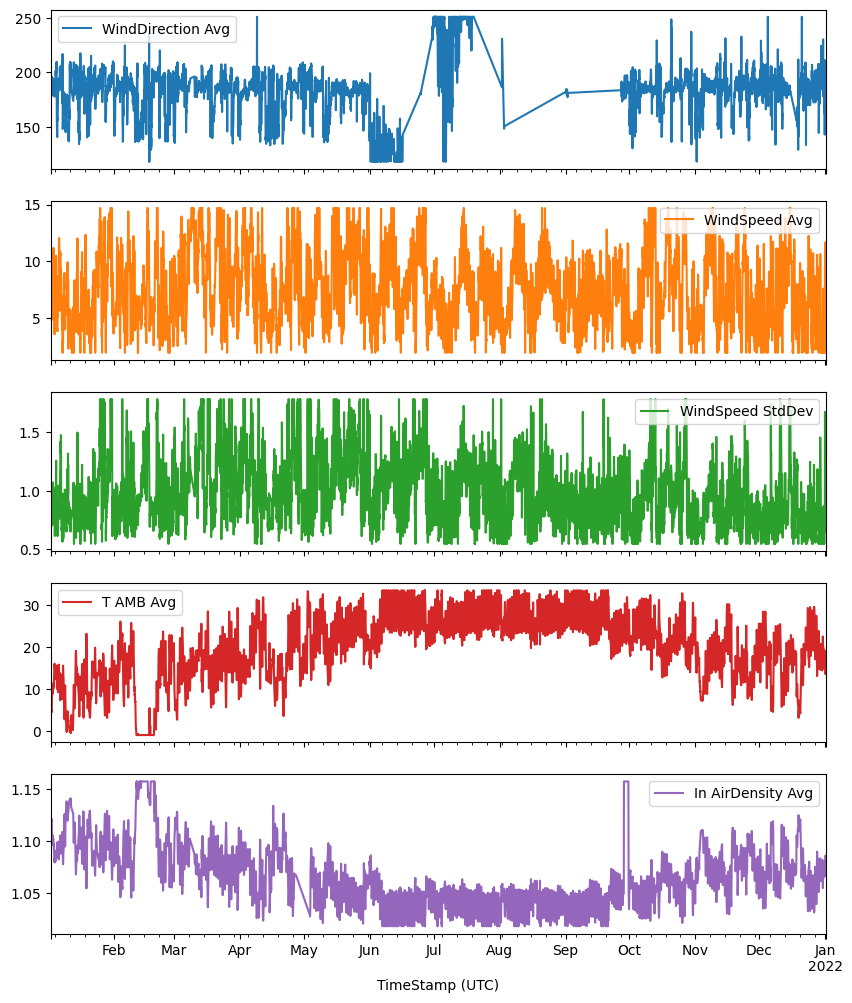

In [732]:
for col in df_clean.columns:
    upper = df_clean[col].quantile(0.98)
    lower = df_clean[col].quantile(0.02)
    print(col)
    print("Min=",df_clean[col].min(), "Max=",df_wf[col].max(), "98%",upper, "2%",lower)
    df_clean[col]=df_clean[col].clip(lower=lower, upper=upper)#.plot(figsize=(10, 6), label='clipped')

df_clean.plot(subplots=True, figsize=(10, 12))

## Univariate Time Series Analysis

The problem asks for forecast of windspeed over next 48 hours. So let's focus our analysis on `WindSpeed Avg` variable.

In [733]:
df_uni =  pd.DataFrame(df_clean['WindSpeed Avg'])
# df_uni

Breaking down time-series into trend, seasonality and residue to understand the underlying pattern in data

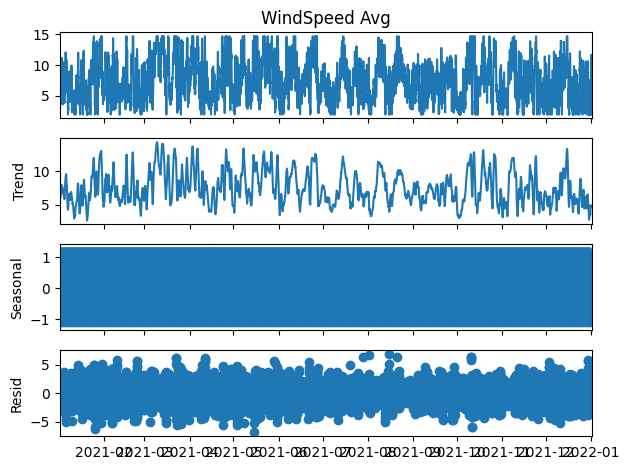

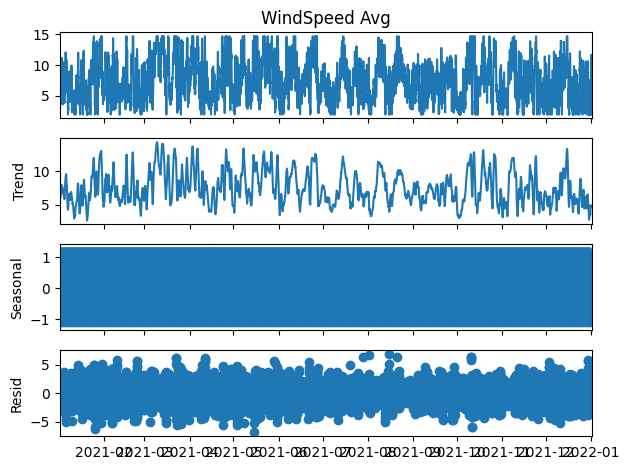

In [734]:
mdl_sd = sm.tsa.seasonal_decompose(df_uni['WindSpeed Avg'], model = 'additive')
mdl_sd.plot()

<Axes: title={'center': 'Seasonality of WindSpeed Avg over 5 days'}, xlabel='TimeStamp (UTC)'>

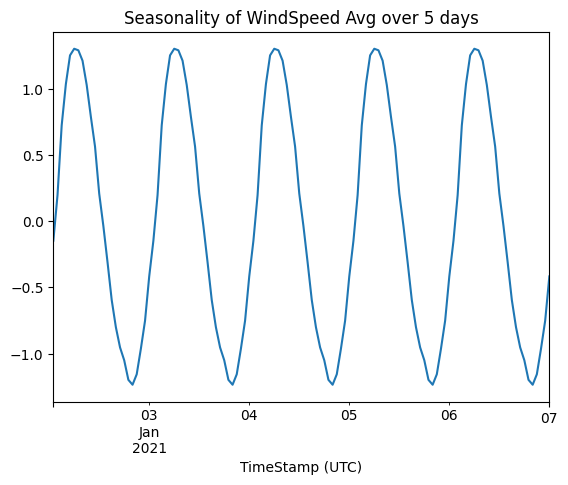

In [735]:
# model exhibit pretty clear seasonality
mdl_sd.seasonal[:120].plot(title='Seasonality of WindSpeed Avg over 5 days')

<Axes: >

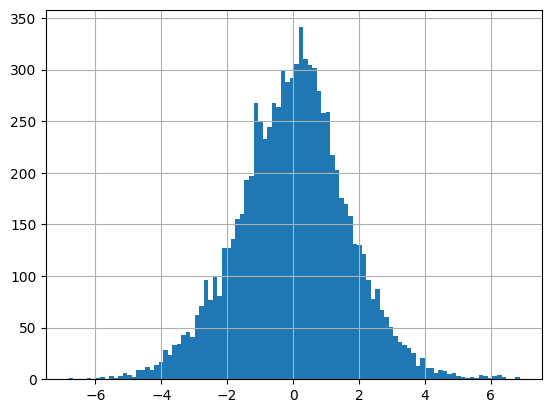

In [736]:
mdl_sd.resid.hist(bins=100)

In [737]:
mdl_sd.resid.mean()

np.float64(-0.0009880892332990408)

- There is no outstanding trend. observed. 
- Model exhibit pretty clear seasonality. 
- Residue is normally distributed and centered around 0. 

The trend and seasonality captures the core information about the `WindSpeed Avg` signal.

### Stationarity

Test stationarity of time-series using adafuller test

In [738]:
def test_stationarity(x):
    return 'Series is stationary' if sm.tsa.stattools.adfuller(x)[1] <= 0.05 else 'Series is not stationary'

test_stationarity(df_uni['WindSpeed Avg'])

'Series is stationary'

Identify the periodicity of the seasonality using AutoCorrelation 

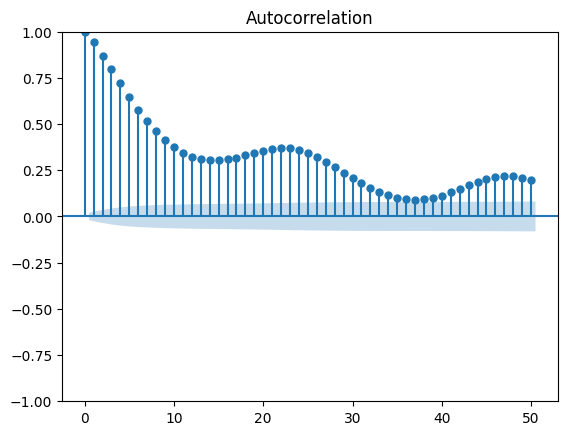

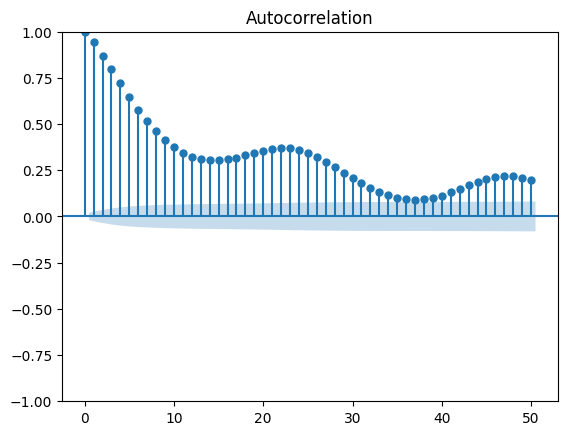

In [739]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_uni['WindSpeed Avg'],lags=50)

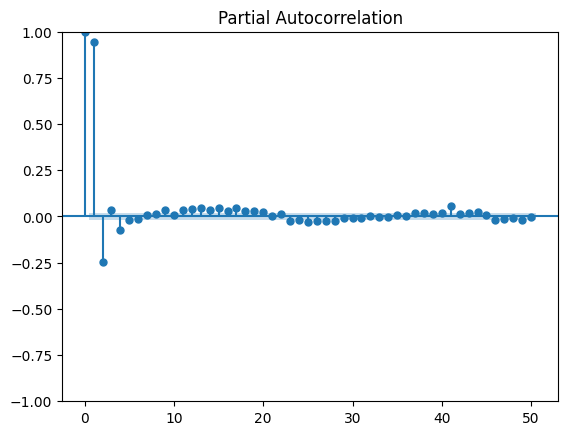

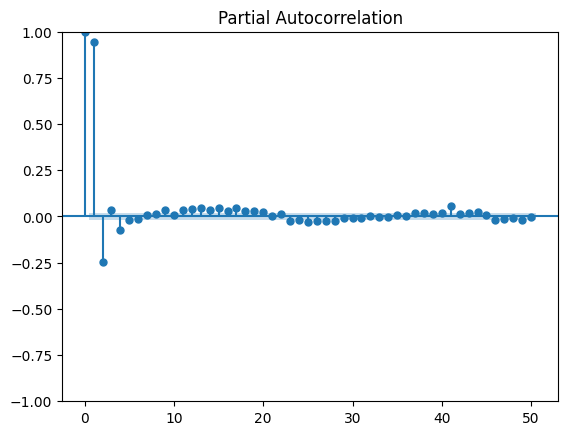

In [740]:
plot_pacf(df_uni['WindSpeed Avg'], lags=50)

#### Prepare Datasets

Split data into train and test sets. 90% data in training and 10% in testing

In [742]:
# df_uni.index[int(0.8*len(df_uni))]
# create training and test sets. Use all data except last 48hrs as training set
train_uni = df_uni[:df_uni.index[-49]] #df_uni[:df_uni.index[int(0.9*len(df_uni)-1)]]
test_uni = df_uni[df_uni.index[-48]:] #df_uni[df_uni.index[int(0.9*len(df_uni))]:]

# train_uni.shape, test_uni.shape, len(df_uni), train_uni.isna().sum(), test_uni.isna().sum()   

## Baseline models

### Persistance model
It is the very simplest form of forecast model, where forecast at current time instant is value at previous time instant

$\hat{x}_{t} = x_{t-1}$

MSE: 9.57
MAE: 1.989
RMSE: 3.093
MAPE: 0.363


/tmp/ipykernel_1727/358306899.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_uni.loc[:,'pred'] = train_uni['WindSpeed Avg'][-1]#test_uni['WindSpeed Avg'].shift(1)


<Axes: xlabel='TimeStamp (UTC)'>

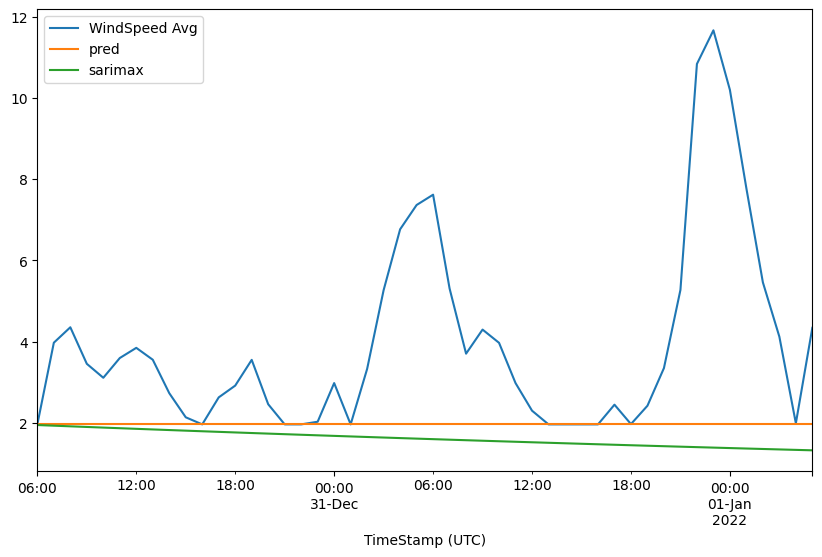

In [754]:
# shift the data by 1 for predictions
test_uni.loc[:,'pred'] = train_uni['WindSpeed Avg'][-1]#test_uni['WindSpeed Avg'].shift(1)

# model_performance(test_uni['WindSpeed Avg'], test_uni['pred'])
# Data frame to track model performance
df_metrics = pd.DataFrame(model_performance(test_uni['WindSpeed Avg'], test_uni['pred']),index=['Persistance Model'])
test_uni.plot(figsize=(10, 6))

The simplest forecast model produces pretty good forecasts. But it's horizon of forecast is 1 hour into future. It may not be good for our scenario where we needed to forecast for 48 hours horizon, as we can see from the graph the forecast is just a flat-line. But this can be used as baseline model to compare performance of more complex model.

## Models



Start with Seasonal ARIMA model with default parameters

In [755]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

MSE: 11.399
MAE: 2.335
RMSE: 3.376
MAPE: 0.47


/home/owl/learning/assign/avathon/myenv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/owl/learning/assign/avathon/myenv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


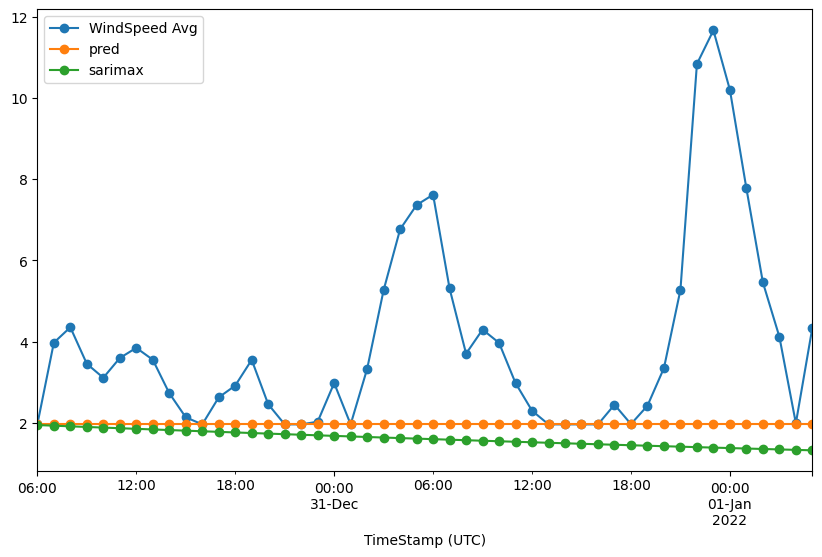

In [756]:
mdl_sarimax = SARIMAX(train_uni['WindSpeed Avg'])
mdl_sarimax = mdl_sarimax.fit(disp=False)

test_uni.loc[:,'sarimax'] = mdl_sarimax.forecast(steps=48) #predict(start=test_uni.index[0], end=test_uni.index[-1])

test_uni.plot(style='-o', figsize=(10, 6))
# model_performance(test_uni['WindSpeed Avg'], test_uni['sarimax'])
df_metrics.loc['Uni default'] = model_performance(test_uni['WindSpeed Avg'], test_uni['sarimax'])

Manually tune order and seasonal_order parameters.

/home/owl/learning/assign/avathon/myenv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/owl/learning/assign/avathon/myenv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/owl/learning/assign/avathon/myenv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 9.553
MAE: 1.993
RMSE: 3.091
MAPE: 0.365


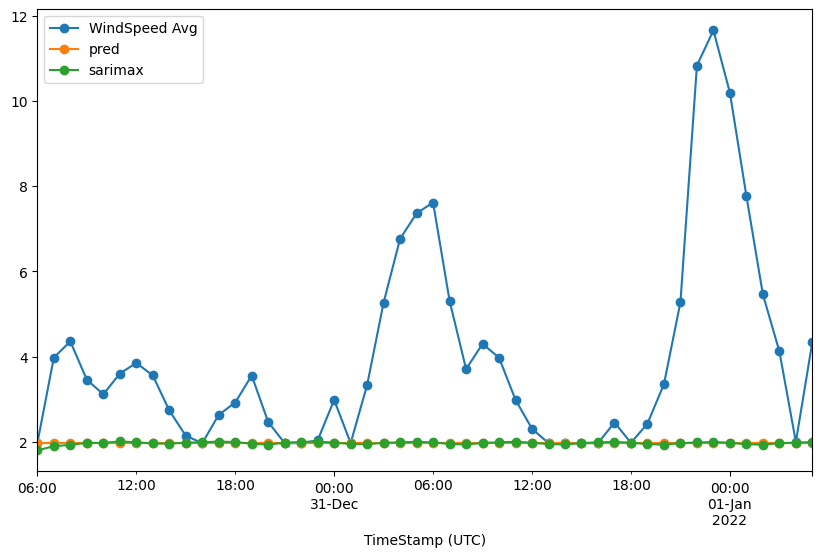

In [787]:
mdl_sarimax = SARIMAX(train_uni['WindSpeed Avg'], 
                      order=(3,1,3), 
                      seasonal_order=(1,1,1,6)
                      )
mdl_sarimax = mdl_sarimax.fit(disp=False)

test_uni.loc[:,'sarimax'] = mdl_sarimax.forecast(steps=48)

test_uni.plot(style='-o', figsize=(10, 6))
df_metrics.loc['Uni tuned'] =  model_performance(test_uni['WindSpeed Avg'], test_uni['sarimax'])

Even though tuning the model improved performance metrics, but the forecast plot clearly shows that the forecast is very poor.
Adding order and seasonal-order does not help in improving the model forecasts. Lets try adding other variables into the model

Exponential Smoothing model

/home/owl/learning/assign/avathon/myenv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


MSE: 11.612
MAE: 2.481
RMSE: 3.408
MAPE: 0.544


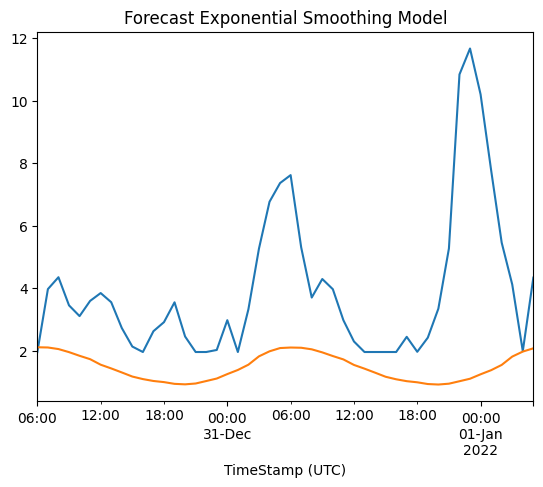

In [865]:
mdl_sm = sm.tsa.ExponentialSmoothing(train_uni['WindSpeed Avg'],
                                     trend='add', 
                                     seasonal='add', 
                                     seasonal_periods=24,
                                     use_boxcox=True
                                     ).fit(smoothing_level=0.8)




# mdl_sm.fittedvalues["2021-12-29 06:00:00":].plot(label='fitted')
# train_uni.loc["2021-12-29 06:00:00":, "WindSpeed Avg"].plot(label='actual')
# test_uni.loc[:"2021-12-31 06:00:00" ,'WindSpeed Avg'].plot(label='test')
plt.title('Forecast Exponential Smoothing Model')
test_uni['WindSpeed Avg'].plot(label='test')
mdl_sm.forecast(48).plot(label='forecast')
df_metrics.loc['Expo Smoothening'] = model_performance(test_uni['WindSpeed Avg'], mdl_sm.forecast(48))

Exponential model is no better at forecasting. The forecast is a superimposition of last known value of WindSpeed and seasonal pattern.  

## Multi-variate time-series analysis

### Prepare Dataset

In [861]:
df_multi = df_clean.copy()

multi_train = df_multi[:df_multi.index[-49]]
multi_test = df_multi[df_multi.index[-48]:]

### Model

Use SARIMAX model with exogenous variables

/home/owl/learning/assign/avathon/myenv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/owl/learning/assign/avathon/myenv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


MSE: 7.337
MAE: 1.72
RMSE: 2.709
MAPE: 0.342


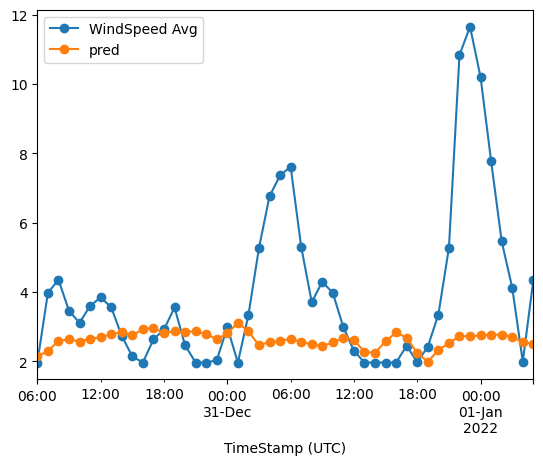

In [866]:
# mdl_multi = SARIMAX(multi_train['WindSpeed Avg'], exog=multi_train.drop('WindSpeed Avg', axis=1), order=(2,1,2), seasonal_order=(1,1,1,24))

regressors = [
            'WindDirection Avg' , 
            # 'T AMB Avg', 
            # 'In AirDensity Avg',
            #  'WindSpeed StdDev'
            ]

mdl_multi = SARIMAX(multi_train['WindSpeed Avg'], exog=multi_train[regressors], 
                    order=(1,0,0),#(3,2,3),#(3,2,3), 
                    seasonal_order=(2,0,1,6) #(2,0,1,6)
                    )
mdl_multi = mdl_multi.fit(disp=False)

multi_test.loc[:,'pred'] = mdl_multi.forecast(steps=48, 
                                              exog=multi_test[regressors]
                                              )

multi_test[['WindSpeed Avg','pred']].plot(style='-o')
df_metrics.loc["Multi SARIMAX"] = model_performance(multi_test['WindSpeed Avg'], multi_test['pred'])

**Model Tuning:**

Manually tuning the SARIMAX model with different regressors and found the following hyperparameter that works optimally for each configuration.

|Predictors| Hperparameters|
|-|-|
|WindDirection Avg|order=(1,0,0), seasonal_order=(2,0,1,6)|
|WindDirection Avg, T AMB Avg|order=(3,2,3), seasonal_order=(2,0,1,6)|
|WindDirection Avg, T AMB Avg, In AirDensity Avg|order=(3,2,3), seasonal_order=(2,0,1,6)|


The first configuration (*WindDirection Avg as regressor and order=(1,0,0), seasonal_order=(2,0,1,6) as hyperparameter*) in table yielded best results. This model performance is comparable with baseline models. 

In [871]:
# table of performance metrics for model
df_metrics

,MSE,MAE,RMSE,MAPE
Persistance Model,9.570,1.989,3.093,0.363
Uni default,11.399,2.335,3.376,0.470
Uni tuned,9.553,1.993,3.091,0.365
Expo Smoothening,11.612,2.481,3.408,0.544
Multi SARIMAX,7.337,1.720,2.709,0.342


### Conclusion

Multi-variate model performs best among the models, but they are unsuitable for the problem as they are dependent of regressor(predictor) variables for forecast.

**Tuned Univariate (Uni tuned) model has scores comparable to persistance model. This model is chosen for forecasting.**

**It is important for the end-user to gauge the model accuracy across all the forecast values. MAE is the appropriate metric to use in this scenario.**

# Exercise 2 Anomaly Detection

## Load Data

In [433]:
df_ano = pd.read_csv('anomaly_detection.csv')

# set date time index
df_ano.index = pd.date_range(start='2016-01-01', end='2016-12-31', freq='D')[:-1]


df_ano.head()

,CEACC,CCDEF,FAXAE,FBFFD,EDDAB
2016-01-01,0.000000,0.000000,3.000000,3.000000,8.000000
2016-01-02,1.232260,-0.217305,3.193780,3.489992,7.792553
2016-01-03,2.540129,0.606709,3.180950,3.464811,7.817440
2016-01-04,5.520271,1.470812,3.330528,2.968375,7.409152
2016-01-05,5.914298,2.745060,3.061706,3.440980,7.153049


In [434]:
df_ano.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2016-01-01 to 2016-12-30
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CEACC   365 non-null    float64
 1   CCDEF   365 non-null    float64
 2   FAXAE   365 non-null    float64
 3   FBFFD   365 non-null    float64
 4   EDDAB   365 non-null    float64
dtypes: float64(5)
memory usage: 17.1 KB


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

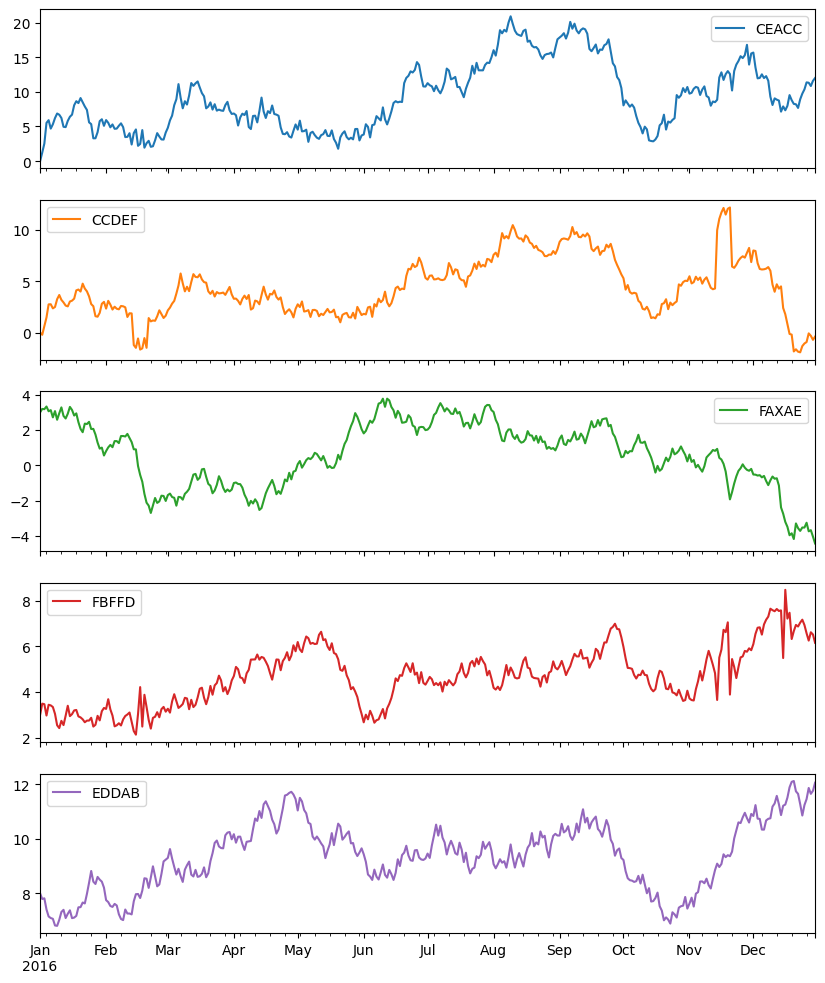

In [435]:
df_ano.plot(subplots=True, figsize=(10, 12))

array([[<Axes: title={'center': 'CEACC'}>,
        <Axes: title={'center': 'CCDEF'}>],
       [<Axes: title={'center': 'FAXAE'}>,
        <Axes: title={'center': 'FBFFD'}>],
       [<Axes: title={'center': 'EDDAB'}>, <Axes: >]], dtype=object)

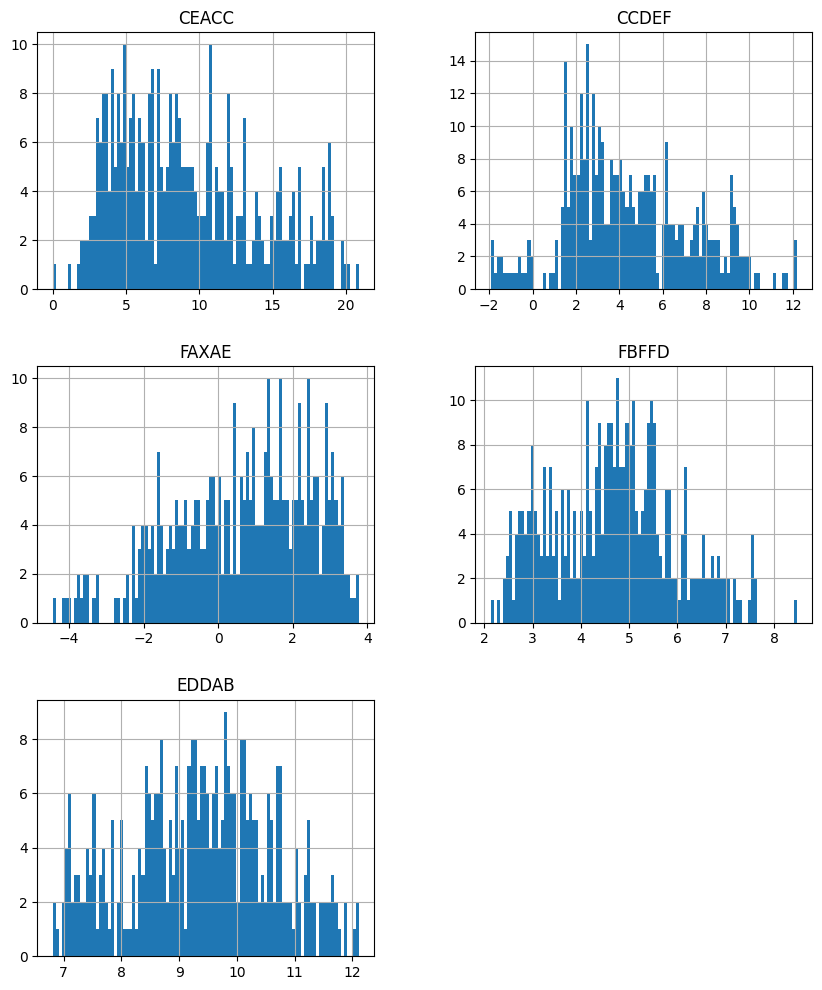

In [439]:
df_ano.hist(figsize=(10, 12),bins=100)

## Prepare Dataset

In [456]:
df_train = df_ano[:"2016-09-30"]
df_test = df_ano["2016-10-01":]

# set outcome variable 0 for normal and 1 for anomalous
df_train['Y'] = 0
# set the dates when anomalous behavior is observed
df_train.loc["2016-02-14":"2016-02-21",'Y'] = 1

df_train["2016-02-10":"2016-02-25"]

/tmp/ipykernel_1727/3856234404.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Y'] = 0


,CEACC,CCDEF,FAXAE,FBFFD,EDDAB,Y
2016-02-10,3.473757,2.461319,1.630802,2.948132,7.406645,0
2016-02-11,3.505408,1.518704,1.777356,3.014397,7.260162,0
2016-02-12,4.031660,1.878732,1.551201,3.101520,7.260178,0
2016-02-13,2.398371,1.865553,1.314152,2.701644,7.228020,0
2016-02-14,4.043725,-1.219565,0.905195,2.288989,7.709211,1
2016-02-15,4.576282,-1.492071,0.899782,2.130575,7.968487,1
2016-02-16,2.210294,-0.576621,-0.044090,3.037759,7.975463,1
2016-02-17,2.482837,-1.658767,-0.550546,4.215023,7.828515,1
2016-02-18,4.480263,-1.545013,-0.934196,2.485914,8.099992,1
2016-02-19,1.943677,-0.539503,-1.623672,3.877839,8.551997,1


In [467]:
df_train['Y'].value_counts(normalize=True)

Y
0    0.970803
1    0.029197
Name: proportion, dtype: float64

## Model

The dataset is already processed, we can go ahead to develop the model for anomaly detection. I chose to use Isolation Forest model as they are very specialized algorithms for detecting anomalies.



In [515]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix , classification_report, f1_score, recall_score, precision_score

mdl_iso = IsolationForest(random_state=42, contamination=0.03)
# mdl_iso.fit(df_train.drop('Y', axis=1), df_train['Y'])
mdl_iso.fit(df_train.drop('Y', axis=1))

IsolationForest(contamination=0.03, random_state=42)

In [516]:
df_results = df_train.copy()

# df_results['anomaly_scores'] = mdl_iso.decision_function(df_train.drop('Y', axis=1))
df_results['anomaly']=mdl_iso.predict(df_train.drop('Y', axis=1))

df_results.loc[df_results['anomaly']==1,'anomaly'] = 0
df_results.loc[df_results['anomaly']==-1,'anomaly'] = 1

df_results['anomaly'].value_counts()

anomaly
0    265
1      9
Name: count, dtype: int64

In [517]:
def compute_metrics(act, pred):
    print("Confusion Matrix \n", confusion_matrix(act, pred))
    print("Classification Report", classification_report(act, pred))
    print("Precision", precision_score(act, pred))
    print("Recall", recall_score(act, pred))
    print("F1 Score", f1_score(act, pred))

# confusion_matrix(df_results['Y'], df_results['anomaly']), f1_score(df_results['Y'], df_results['anomaly'])
compute_metrics(df_results['Y'], df_results['anomaly'])

Confusion Matrix 
 [[263   3]
 [  2   6]]
Classification Report               precision    recall  f1-score   support

           0       0.99      0.99      0.99       266
           1       0.67      0.75      0.71         8

    accuracy                           0.98       274
   macro avg       0.83      0.87      0.85       274
weighted avg       0.98      0.98      0.98       274

Precision 0.6666666666666666
Recall 0.75
F1 Score 0.7058823529411765


The model does very well did decent job in predicting the anomalies, it did has a very good (98%) accuracy in classifying the normal samples. Lets use this model to analyze the test dataset

In [640]:
# Anomaly prediction on test data

preds = mdl_iso.predict(df_test)

# reset the predicted labels to match the original labels (0: normal, 1: anomalous)
preds[preds==1]=0
preds[preds==-1]=1

df_preds = pd.DataFrame(data={'preds': preds}, 
                        index=df_test.index)



# first order difference of the predictions to find when anomaly starts and ends
df_preds['diff'] = df_preds['preds'].diff(1)
df_preds = df_preds.fillna(0)

an_days = 0
is_anomaly = False
an_start = ''
for i, row in df_preds.iterrows():
    if row['diff'] == -1 or i == df_preds.index[-1]: # anomaly end
        # print(an_days)
        is_anomaly = False
        if an_days <= 14:
            print(f"Anomaly started at {an_start} and ended at {i} and lasted for {an_days} days")    
    elif row['diff'] == 1: # anomaly start
        is_anomaly = True
        an_start = i
        
    if is_anomaly:    
        an_days += 1
    else :
        an_days = 0

    
    


Anomaly started at 2016-11-16 00:00:00 and ended at 2016-11-21 00:00:00 and lasted for 5 days


In [642]:
# save the model in pickle file for usage in model deployment
import pickle

with open('anomaly_detection.pkl', 'wb') as f:
    pickle.dump(mdl_iso, f)

# Model Deployment

This block of code goes into app.py script. Run the script in console to start the Flask api server. The prediction end-point shall be reached at url "http://127.0.0.1:5000/predict". 

The api end-point takes the csv file as string and loads into data frame which is input to model for prediction. The end-point shall respond with the predictions (0-normal, 1-anomaly).

In [ ]:
# app.py
from flask import Flask, request
import json
import pickle
import pandas as pd
from io import StringIO

app = Flask(__name__)
model = pickle.load(open('anomaly_detection.pkl', 'rb'))

def get_df(data):
    return pd.read_csv(StringIO(data), sep=',')
    # _data = json.loads(data)
    # return pd.DataFrame(_data, index=range(len(_data)))

@app.route('/predict', methods=['POST'])
def predict():
    df = get_df(request.json['data'])
    preds = model.predict(df)
    # reset the predicted labels to match the original labels (0: normal, 1: anomalous)
    preds[preds==1]=0
    preds[preds==-1]=1

    return json.dumps(preds.tolist())

if __name__ == '__main__':
    app.run(debug=True)

Using requests module to test our api. 

In [722]:
import requests
# import json
# data = df_ano.to_dict('records')
with open('anomaly_detection.csv','r') as f:
    data = f.read()
response = requests.post('http://127.0.0.1:5000/predict', json={'data': data})
response.content.decode('utf-8')

'[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,